In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

C:\Users\cep4u\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\cep4u\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\cep4u\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
# Define the TF-IDF vectorizer with desired parameters
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda x: [word_pos[0] for word_pos in eval(x)],
                                   lowercase=False,
                                   stop_words=None)

def tfidf_vectorize(data, column):
    # Fit and transform the specified column
    tfidf_vectors = tfidf_vectorizer.fit_transform(data[column])

    # Return the resulting sparse matrix
    return tfidf_vectors

In [3]:
def train_model(X, y, num_classes):
    # Initialize a KFold object with 5 folds
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Create lists to store the training history and trained models for each fold
    histories = []
    models = []

    # Iterate over the folds and train the model on each one
    for fold, (train_indices, val_indices) in enumerate(kfold.split(X, y)):
        # Split the data into training and validation sets for this fold
        X_train, y_train = X[train_indices], y[train_indices]
        X_val, y_val = X[val_indices], y[val_indices]

        # Create a sequential model with a single dense output layer
        model = keras.Sequential([
            keras.layers.Dense(units=num_classes, activation='softmax', input_shape=(X.shape[1],))
        ])

        # Compile the model with categorical crossentropy loss and adam optimizer
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        # Train the model on the input data
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

        # Add the trained model and training history to the lists
        models.append(model)
        histories.append(history)

    # Return the list of trained models and training histories
    return models, histories

In [4]:
df = pd.read_csv("C:\\Users\\cep4u\\JHU Classes\\Classes\\Spring 2023\\Theory of Machine Learning\\Group Project\\625.742-Theory-of-Machine-Learning\\News Category Dataset Cleaned 20230416.csv")

In [6]:
categories = ['WELLNESS & HEALTH','ENTERTAINMENT','TRAVEL', 'STYLE & BEAUTY', 'PARENTING', 'QUEER VOICES', 'FOOD & DRINK']
data = df[df['category'].isin(categories)]

sampled_data = data.groupby('category', group_keys=False).apply(lambda x: x.sample(n=3000))

# Encode the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(sampled_data['category'])

# Vectorize the text data using TF-IDF
X_sparse = tfidf_vectorize(sampled_data, 'wordnet_pos_hdl')

In [8]:
# Withold validation set.
X_train_sparse, X_val_sparse, y_train, y_val = train_test_split(X_sparse, y, test_size=0.2, random_state=12)

# Convert the sparse matrices to dense arrays
X = X_train_sparse.toarray()

# Convert the target variable to a one-hot encoded matrix
num_classes = len(label_encoder.classes_)
y_onehot = keras.utils.to_categorical(y_train, num_classes)

In [9]:
# Train the neural network on the training data
models, histories = train_model(X, y_onehot, num_classes)

Train on 13440 samples, validate on 3360 samples
Epoch 1/10
13440/13440 [==============================] - 3s 240us/sample - loss: 1.8962 - accuracy: 0.5737 - val_loss: 1.8473 - val_accuracy: 0.7125
Epoch 2/10
13440/13440 [==============================] - 3s 197us/sample - loss: 1.7662 - accuracy: 0.8522 - val_loss: 1.7536 - val_accuracy: 0.7396
Epoch 3/10
13440/13440 [==============================] - 3s 196us/sample - loss: 1.6424 - accuracy: 0.8847 - val_loss: 1.6672 - val_accuracy: 0.7479
Epoch 4/10
13440/13440 [==============================] - 3s 190us/sample - loss: 1.5272 - accuracy: 0.8967 - val_loss: 1.5877 - val_accuracy: 0.7497
Epoch 5/10
13440/13440 [==============================] - 3s 192us/sample - loss: 1.4210 - accuracy: 0.9032 - val_loss: 1.5150 - val_accuracy: 0.7521
Epoch 6/10
13440/13440 [==============================] - 3s 213us/sample - loss: 1.3236 - accuracy: 0.9085 - val_loss: 1.4490 - val_accuracy: 0.7506
Epoch 7/10
13440/13440 [===========================

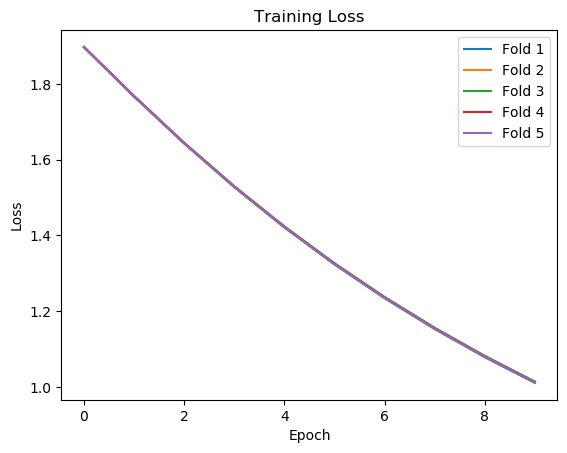

In [10]:
# Plot the training loss over epochs for all folds
for fold, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f"Fold {fold + 1}")
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
loss_avg = []
acc_avg = []
X_val = X_val_sparse.toarray()
y_onehot_val = keras.utils.to_categorical(y_val, num_classes)
for model in models: # Evaluate the model on the testing data
    loss, accuracy = model.evaluate(X_val, y_onehot_val)
    loss_avg.append(loss)
    acc_avg.append(accuracy)
    
print('Test loss:', sum(loss_avg)/len(loss_avg))
print('Test accuracy:', sum(acc_avg)/len(acc_avg))

4200/4200 [==============================] - 1s 170us/sample - loss: 1.2238 - accuracy: 0.7586
Test loss: 1.224737948054359
Test accuracy: 0.7569047570228576
